<a href="https://colab.research.google.com/github/littlefieldnick/imbalanced-data-modeling/blob/main/1_2_oversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchtext
import torchtext.data as data
import torchtext.datasets.imdb as imdb
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Part 1: Data Extraction and Exploration 

In [ ]:
TEXT = data.Field(sequential=True, init_token="<start>", batch_first=True)
LABEL = data.LabelField(sequential=False, use_vocab=True)
EPOCHS = 10

In [ ]:
train, test = imdb.IMDB.splits(TEXT, LABEL)

In [ ]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [ ]:
TEXT.vocab.stoi["<start>"]

2

In [ ]:
pos_reviews = [example for example in train.examples if example.label == "pos"]
neg_reviews = [example for example in train.examples if example.label == "neg"]

In [ ]:
pos_lengths = [len(x.text) for x in pos_reviews]
neg_lengths = [len(x.text) for x in neg_reviews]

In [ ]:
pos_review_lengths = list(map(lambda x: len(x.text), pos_reviews))
neg_review_lengths = list(map(lambda x: len(x.text), neg_reviews))

In [ ]:
from collections import Counter
freq_pos_len = Counter(pos_lengths).most_common(1)
freq_neg_len = Counter(neg_lengths).most_common(1)

In [ ]:
print("The most common positive review length is {} words ({} reviews)".format(freq_pos_len[0][0], freq_pos_len[0][1]))
print("The most common negative review length is {} words ({} reviews)".format(freq_neg_len[0][0], freq_neg_len[0][1]))

The most common positive review length is 124 words (99 reviews)
The most common negative review length is 123 words (106 reviews)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

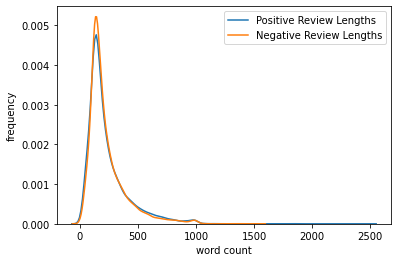

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(pos_review_lengths, label="Positive Review Lengths")
sns.kdeplot(neg_review_lengths, label="Negative Review Lengths")
ax.set(xlabel='word count', ylabel='frequency')
ax.legend()

### Part 2: Oversampling

In [ ]:
pos_review_idx = list(range(0, len(pos_reviews)))
np.random.shuffle(pos_review_idx)

In [ ]:
pos_minority = pos_review_idx[:int(len(pos_review_idx) * 0.5)]

In [ ]:
def shuffle(data, return_size=250):
  np.random.shuffle(data)
  return data[:return_size]

In [ ]:
sampled_pos_reviews = np.tile(shuffle(pos_minority), 25)
sampled_pos_reviews[0]

8024

In [ ]:
pos_review_idx = np.concatenate([pos_minority, sampled_pos_reviews])

In [ ]:
pos_review_idx

array([ 8024,  9216,  2541, ...,  7152, 10050,  3132])

In [ ]:
pos_reviews = [train[idx] for idx in pos_review_idx]

In [ ]:
train_x = np.concatenate([neg_reviews, pos_reviews])

In [ ]:
# Rebuild Torchtext dataset to use downsampled neg reviews and upsampled pos reviews
train_sampled = data.Dataset(train_x, [('text', TEXT), ('label', LABEL)])

In [ ]:
strt_token = "<START>"
pad_token = "<PAD>"

In [ ]:
TEXT.build_vocab(train_sampled)
LABEL.build_vocab(train_sampled)

In [ ]:
train_dl = data.BucketIterator(train_sampled, 128, device=DEVICE)
test_dl = data.BucketIterator(test, 128, device=DEVICE)

In [ ]:
X, y = next(iter(train_dl))

In [ ]:
class ImbalancedData(nn.Module):
  def __init__(self, embedding_dim, embedding_size, num_layers, output_size, hidden_size):
    super(ImbalancedData, self).__init__()
    self.embedding_size = embedding_size
    self.num_layers = num_layers

    self.embedding = nn.Embedding(num_embeddings=embedding_size, embedding_dim=embedding_dim, padding_idx=TEXT.vocab.stoi["<PAD>"])
    self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out = self.embedding(x)
    out, _ = self.lstm(out)
    out = self.linear(out)
    return torch.mean(out, keepdims=False, dim=1)

In [ ]:
TEXT.vocab.stoi["<PAD>"]

0

In [ ]:
model = ImbalancedData(300, len(TEXT.vocab.stoi) + 1, 1, 1, 128)
model.cuda()

ImbalancedData(
  (embedding): Embedding(233619, 300, padding_idx=0)
  (lstm): LSTM(300, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

In [ ]:
model.train()
for i in range(1, EPOCHS + 1):
  train_loss = []
  for batch in train_dl:
    optimizer.zero_grad()
    X = batch.text
    y = batch.label.float()
    out = torch.sigmoid(model(X))
    y = y.reshape((len(y), 1))
    loss = loss_fn(out, y)
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  print("Epoch", i, ": Training Loss:", np.mean(np.array(train_loss)))

Epoch 1 : Training Loss: 0.6895699774732396
Epoch 2 : Training Loss: 0.5767414635237382
Epoch 3 : Training Loss: 0.39655739023369185
Epoch 4 : Training Loss: 0.3053244792533164
Epoch 5 : Training Loss: 0.24545513161895227
Epoch 6 : Training Loss: 0.20409255125084702
Epoch 7 : Training Loss: 0.1751527409164273
Epoch 8 : Training Loss: 0.15384361145979897
Epoch 9 : Training Loss: 0.1353061601367532
Epoch 10 : Training Loss: 0.12010294294022784


In [ ]:
def get_preds(model, data):
  final_preds = []
  model.eval()
  for batch in data:
    out = torch.sigmoid(model(batch.text))
    b_pred = [1 if p > 0.5 else 0 for p in out]
    final_preds.extend(b_pred)

  return final_preds

def get_actual_preds(data):
  actual = []
  for batch in data:
    act_v = [1 if y > 0.5 else 0 for y in batch.label]
    actual.extend(act_v)

  return actual

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate

def eval_model(model, data, ds="train"):
  final_preds = get_preds(model, data)
  actual_preds = get_actual_preds(data)

  if ds == "train":
    print("EVALUATING TRAINING SET")
  else:
    print("EVALUATING TEST SET")

  precision = precision_score(actual_preds, final_preds)
  recall = recall_score(actual_preds, final_preds)
  f1 = f1_score(actual_preds, final_preds)
  print(tabulate([[precision, recall, f1]], headers=('Precision', 'Recall', 'F1-Score')))


In [ ]:
eval_model(model, train_dl)

EVALUATING TRAINING SET
  Precision    Recall    F1-Score
-----------  --------  ----------
    0.49842   0.49216     0.49527


In [ ]:
eval_model(model, test_dl, ds="test")

EVALUATING TEST SET
  Precision    Recall    F1-Score
-----------  --------  ----------
    0.49931    0.3764     0.42923
